In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax

from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np
import healpy as hp

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')


In [2]:
from jaxinterp2d import interp2d, CartesianGrid

H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0
speed_of_light = constants.c.to('km/s').value

zMax = 5.0
zgrid = jnp.expm1(np.linspace(np.log(1), np.log(zMax+1), 1000))
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,50)

rs = []
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

2025-02-19 12:33:50.245778: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100%|██████████| 50/50 [00:00<00:00, 80.90it/s]


In [3]:
GWTC1=True

with h5py.File('../../darksirens/posterior_samples/GWTC-3_posterior_samples_m1detm2detdLradec_4096_1peryear.h5', 'r') as inp:
    if GWTC1:
        nsamps = inp.attrs['nsamp']
        nEvents = inp.attrs['nobs']
        ra = jnp.array(inp['ra'])
        dec = jnp.array(inp['dec'])
        m1det = jnp.array(inp['m1det'])
        m2det = jnp.array(inp['m2det'])
        dL = jnp.array((jnp.array(inp['dL'])*u.Mpc).value)
    else:
        nGWTC1 = 10
        nsamps = inp.attrs['nsamp']
        nEvents = inp.attrs['nobs'] - nGWTC1
        ra = jnp.array(inp['ra'])[int(nGWTC1*nsamps):]
        dec = jnp.array(inp['dec'])[int(nGWTC1*nsamps):]
        m1det = jnp.array(inp['m1det'])[int(nGWTC1*nsamps):]
        m2det = jnp.array(inp['m2det'])[int(nGWTC1*nsamps):]
        dL = jnp.array((jnp.array(inp['dL'])*u.Mpc).value)[int(nGWTC1*nsamps):]

nsamp = 4096
ra = ra.reshape(nEvents,nsamps)[:,0:nsamp]#.flatten()
dec = dec.reshape(nEvents,nsamps)[:,0:nsamp]#.flatten()
m1det = m1det.reshape(nEvents,nsamps)[:,0:nsamp]#.flatten()
m2det = m2det.reshape(nEvents,nsamps)[:,0:nsamp]#.flatten()
dL = dL.reshape(nEvents,nsamps)[:,0:nsamp]#.flatten()

# ra = ra[0:nEvents].flatten()
# dec = dec[0:nEvents].flatten()
# m1det = m1det[0:nEvents].flatten()
# m2det = m2det[0:nEvents].flatten()
# dL = dL[0:nEvents].flatten()

p_pe = dL**2#*jnp.cos(dec)*jnp.ones_like(ra)/(4*jnp.pi)

print(nEvents,nsamp)
print(z_of_dL(dL,140,Om0grid[-1]).max())

69 4096
4.728023646248869


In [4]:
@jit
def dV_of_z_normed(z,H0,Om0,gamma):
    dV = dV_of_z(zgrid,H0,Om0)*(1+zgrid)**(gamma-1)
    prob = dV/jnp.trapezoid(dV,zgrid)
    return jnp.interp(z,zgrid,prob)


In [5]:
from jax.scipy.stats import norm

mass = jnp.linspace(1, 250, 2000)
mass_ratio =  jnp.linspace(0, 1, 2000)

def Sfilter_low(m,m_min,dm_min):
    """
    Smoothed filter function

    See Eq. B5 in https://arxiv.org/pdf/2111.03634.pdf
    """
    def f(mm,deltaMM):
        return jnp.exp(deltaMM/mm + deltaMM/(mm-deltaMM))
    
    S_filter = 1./(f(m-m_min,dm_min) + 1.)
    S_filter = jnp.where(m<m_min+dm_min,S_filter,1.)
    S_filter = jnp.where(m>m_min,S_filter,0.)
    return S_filter

def Sfilter_high(m,m_max,dm_max):
    """
    Smoothed filter function

    See Eq. B5 in https://arxiv.org/pdf/2111.03634.pdf
    """
    def f(mm,deltaMM):
        return jnp.exp(deltaMM/mm + deltaMM/(mm-deltaMM))
    
    S_filter = 1./(f(m-m_max,-dm_max) + 1.)
    S_filter = jnp.where(m>m_max-dm_max,S_filter,1.)
    S_filter = jnp.where(m<m_max,S_filter,0.)
    return S_filter

@jit
def logpm1_powerlaw(m1,m_min,m_max,alpha,dm_min,dm_max):

    pm1 = Sfilter_low(mass,m_min,dm_min)*mass**(-alpha)*Sfilter_high(mass,m_max,dm_max)
    pm1 = pm1/jnp.trapezoid(pm1,mass)
    return jnp.log(jnp.interp(m1,mass,pm1))

@jit
def logpm1_peak(m1,mu,sigma):
    pm1 =  jnp.exp(-(mass - mu)**2 / (2 * sigma ** 2))
    pm1 = pm1/jnp.trapezoid(pm1,mass)
    return jnp.log(jnp.interp(m1,mass,pm1))

@jit
def logfq(m1,m2,beta):
    q = m2/m1
    pq = mass_ratio**beta
    pq = pq/jnp.trapezoid(pq,mass_ratio)

    log_pq = jnp.log(jnp.interp(q,mass_ratio,pq))

    return log_pq

In [6]:
@jit
def logpm1_powerlaw_powerlaw_peak(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,mu,sigma,f1,f2):
    p1 = jnp.exp(logpm1_powerlaw(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1))
    p2 = jnp.exp(logpm1_powerlaw(m1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2))
    p3 = jnp.exp(logpm1_peak(m1,mu,sigma))
    
    pm1 = f1*p1 + f2*p2 + (1-f1-f2)*p3
    return jnp.log(pm1)


@jit
def log_p_pop_powerlaw_powerlaw_peak(m1,m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,beta,mu,sigma,f1,f2):
    log_dNdm1 = logpm1_powerlaw_powerlaw_peak(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,mu,sigma,f1,f2)
    log_dNdm2 = logpm1_powerlaw_powerlaw_peak(m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,mu,sigma,f1,f2)
    log_fq = logfq(m1,m2,beta)

    log_p_sz = np.log(0.25) # 1/2 for each spin dimension

    return log_p_sz + log_dNdm1 + log_dNdm2 + log_fq

In [7]:
@jit
def logdiffexp(x, y):
    return x + jnp.log1p(jnp.exp(y-x))

In [8]:
from dynesty.utils import resample_equal
from dynesty import NestedSampler, DynamicNestedSampler
import multiprocessing as multi
import corner
import pickle

dlogz_plplbump = []
dlogz_plplbump_err = []
post_samples_plplbump = []

file = open('PLPLB','rb')
dres = pickle.load(file)

dlogZdynesty = dres.logz[-1]        # value of logZ
dlogZerrdynesty = dres.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

dlogz_plplbump.append(dlogZdynesty)
dlogz_plplbump_err.append(dlogZerrdynesty)

# output marginal likelihood
print('Marginalised evidence (using dynamic sampler) is {} ± {}'.format(dlogZdynesty, dlogZerrdynesty))

# get the posterior samples
dweights = np.exp(dres['logwt'] - dres['logz'][-1])
dpostsamples = resample_equal(dres.samples, dweights)
post_samples_plplbump.append(dpostsamples)
print('Number of posterior samples (using dynamic sampler) is {}'.format(dpostsamples.shape[0]))


Marginalised evidence (using dynamic sampler) is -1518.8368810963589 ± 0.06394353443738376
Number of posterior samples (using dynamic sampler) is 69693


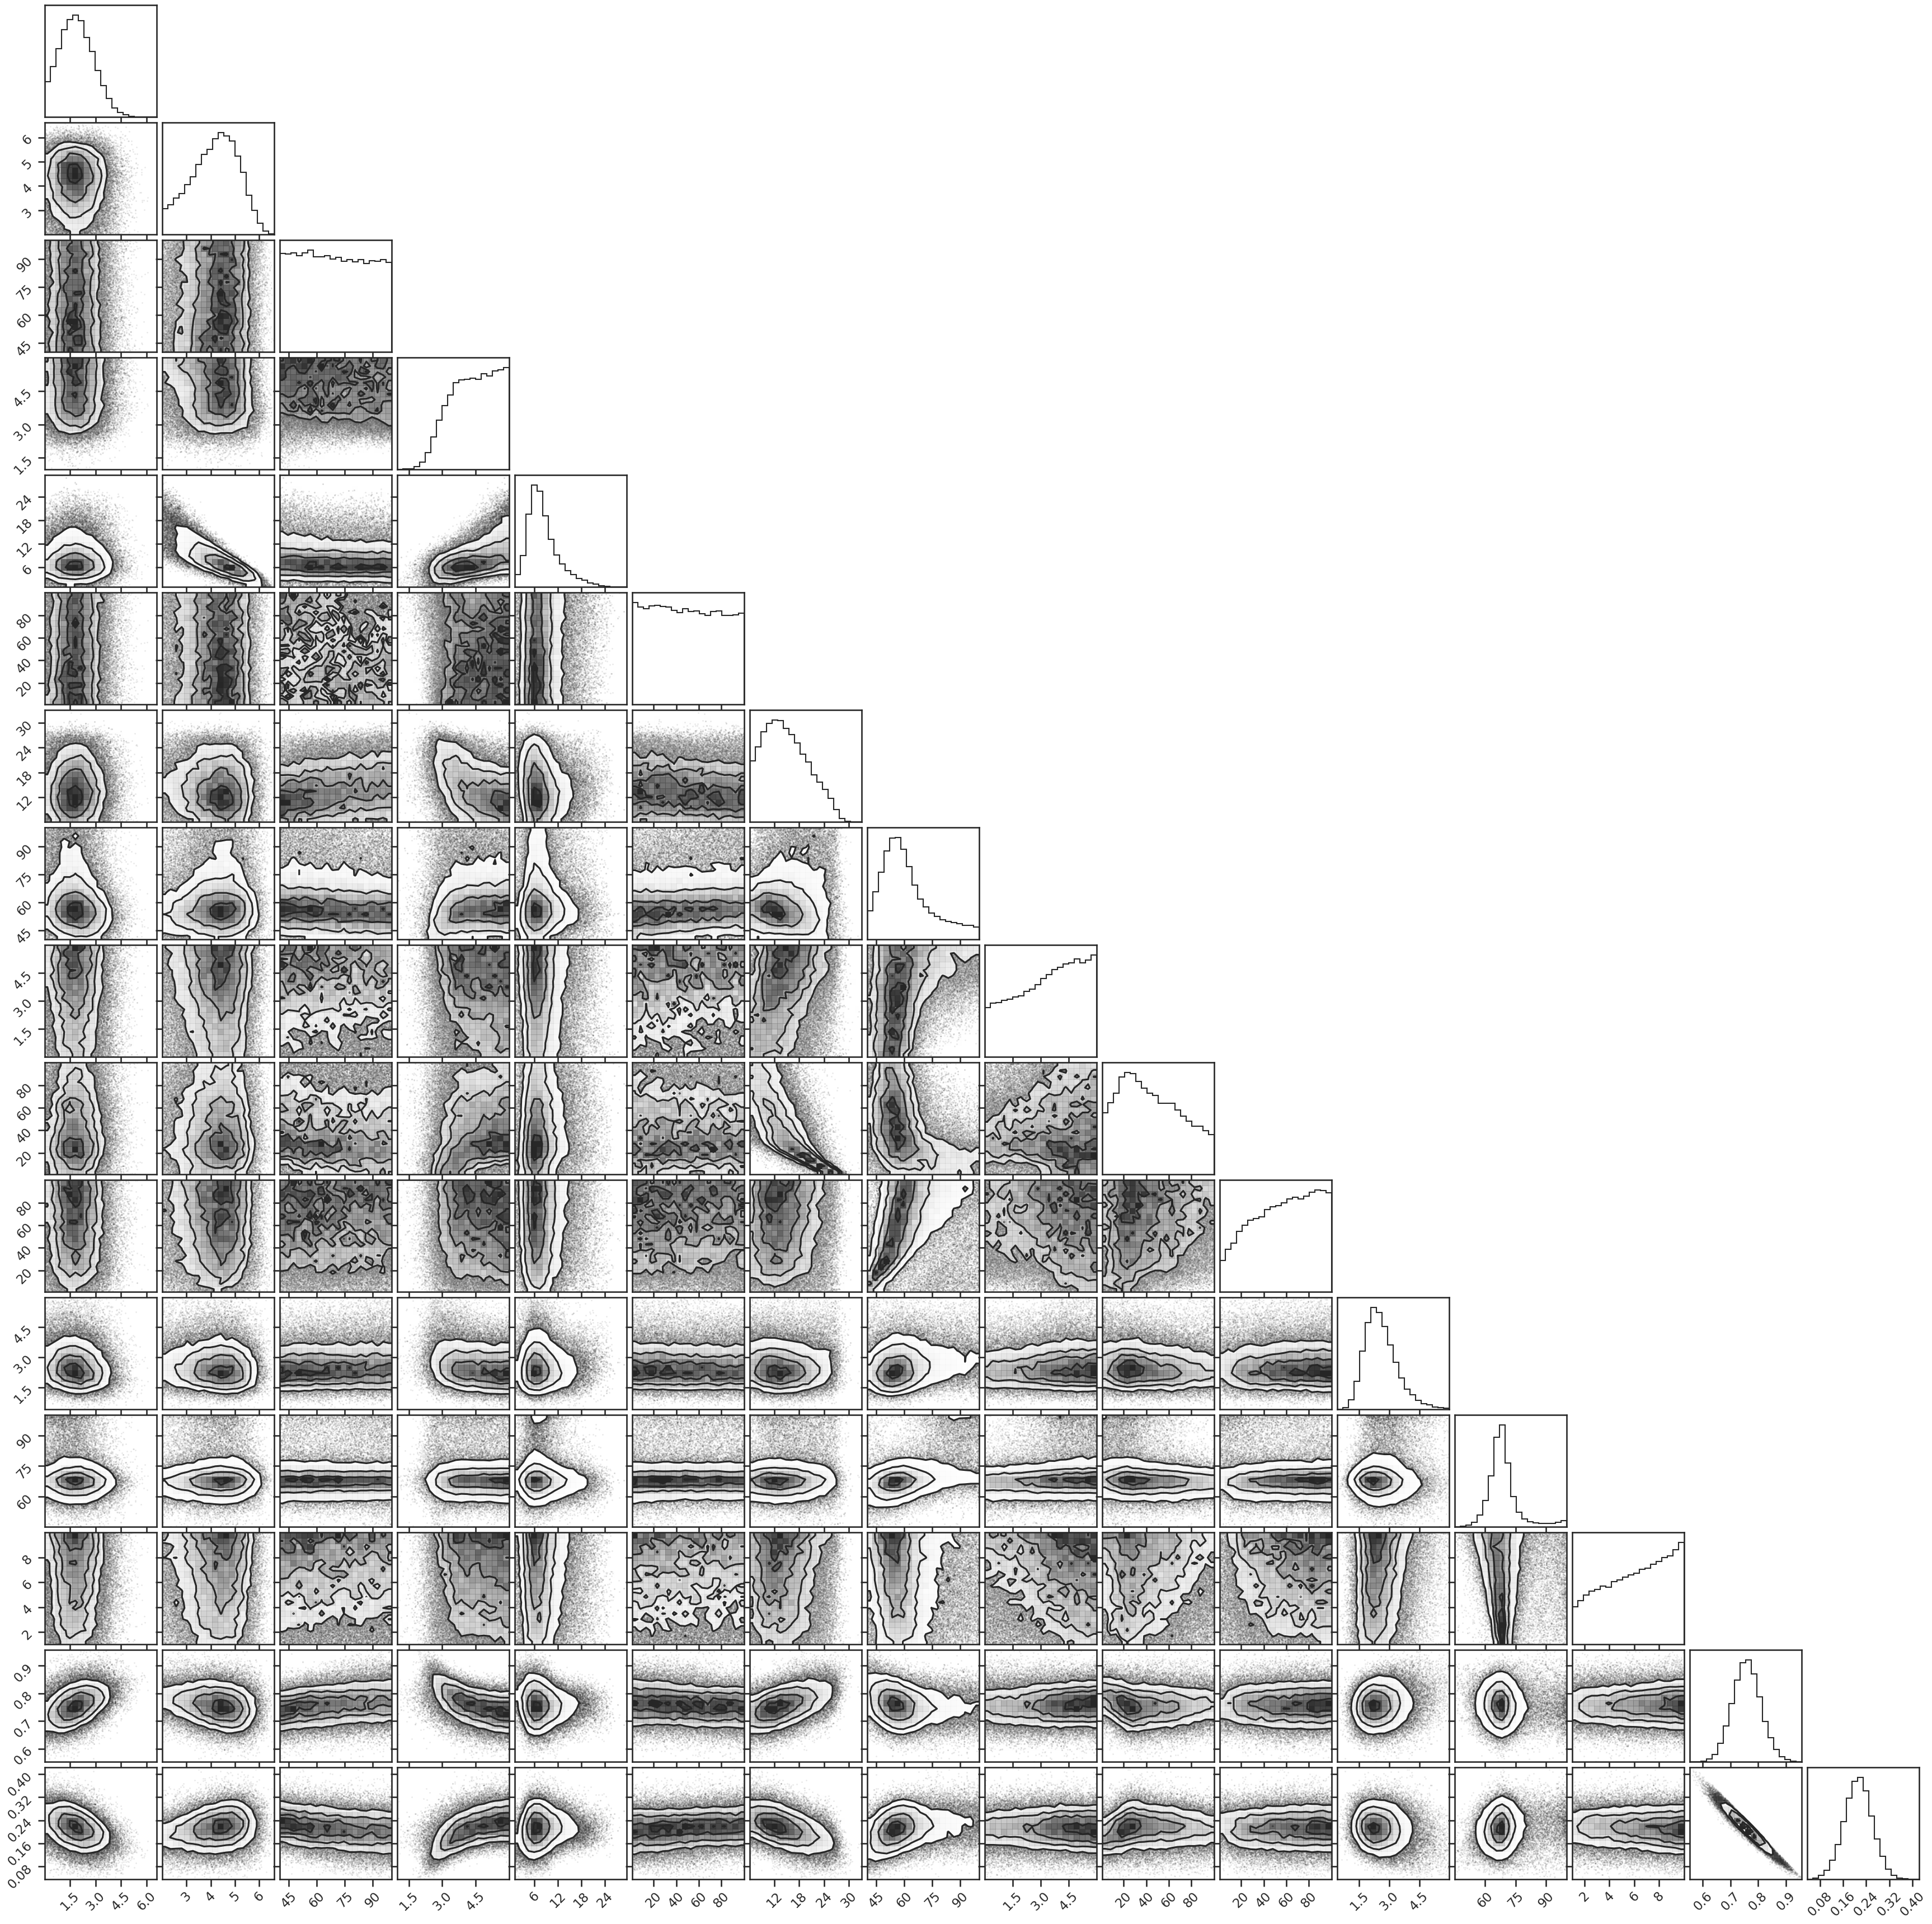

In [9]:
fig = corner.corner(dpostsamples,  hist_kwargs={'density': True})
plt.show()

/tmp/ipykernel_2632665/1114812631.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(1-f1-f2)
/hildafs/home/magana/tmp_ondemand_hildafs_phy230014p_symlink/magana/.conda/envs/jax/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


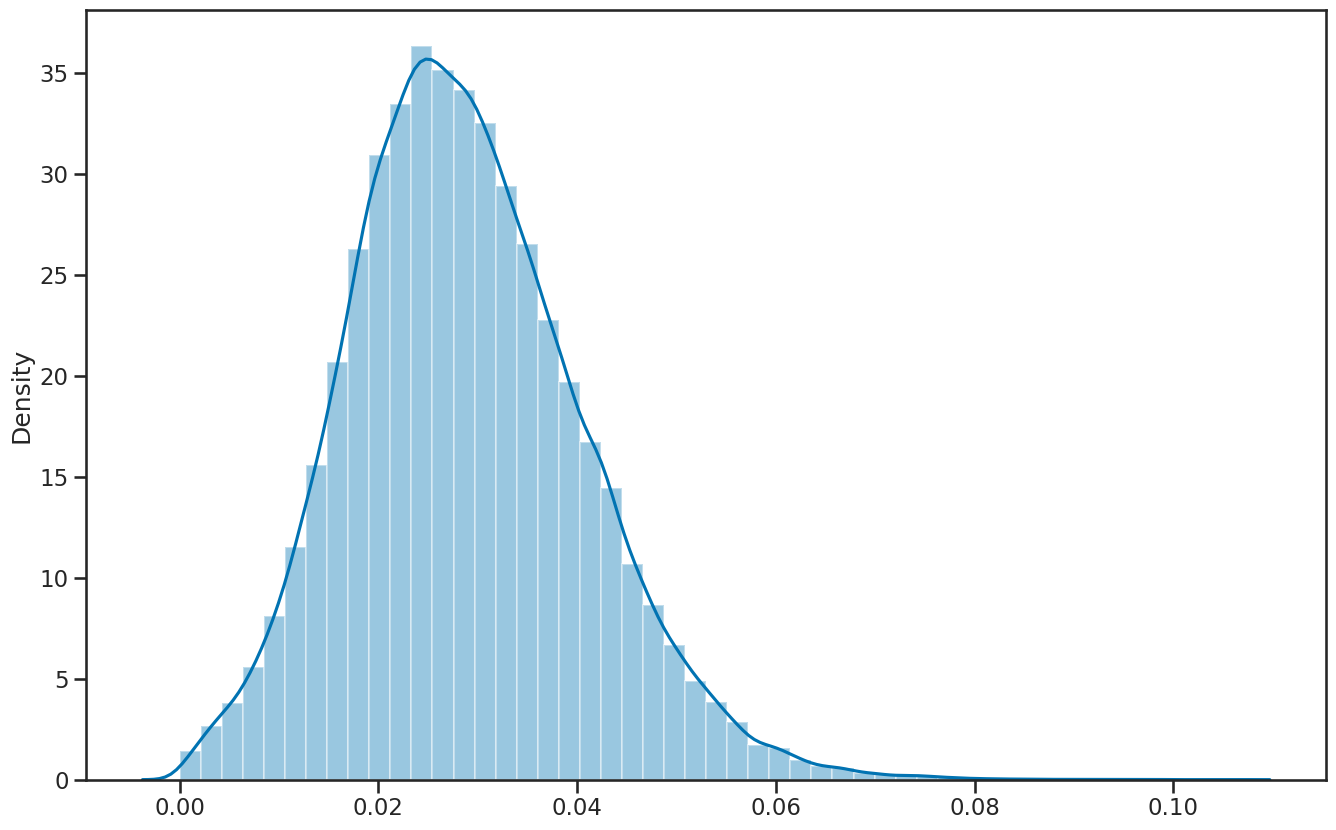

In [10]:
gamma_1 = dpostsamples[:,0]
mmin_1 = dpostsamples[:,1]
mmax_1 = dpostsamples[:,2]
alpha_1 = dpostsamples[:,3]
dm_mmin_1 = dpostsamples[:,4]
dm_mmax_1 = dpostsamples[:,5]
mmin_2 = dpostsamples[:,6]
mmax_2 = dpostsamples[:,7]
alpha_2 = dpostsamples[:,8]
dm_mmin_2 = dpostsamples[:,9]
dm_mmax_2 = dpostsamples[:,10]
beta = dpostsamples[:,11]
mu = dpostsamples[:,12]
sigma = dpostsamples[:,13]
f1 = dpostsamples[:,14]
f2 = dpostsamples[:,15]

sns.distplot(1-f1-f2)
plt.show()


In [11]:
H0 = H0Planck
Om0 = Om0Planck

@jit
def log_weights(m1det,m2det,dL,gamma,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,beta,mu,sigma,f1,f2):

    z = z_of_dL(dL, H0, Om0)
    m1 = m1det/(1+z)
    m2 = m2det/(1+z)

    log_weights = log_p_pop_powerlaw_powerlaw_peak(m1,m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,beta,mu,sigma,f1,f2)

    log_weights += - jnp.log(ddL_of_z(z,dL,H0,Om0)) - jnp.log(p_pe) - 2*jnp.log1p(z) + jnp.log(dV_of_z_normed(z,H0,Om0,gamma))
    
    return log_weights


In [26]:
m1detpop = []
m2detpop = []
dLpop = []

where = np.random.randint(0,len(dpostsamples),5000)
for k in tqdm(where):
    wts = jnp.exp(log_weights(m1det,m2det,dL,*dpostsamples[k]))
    m1detsamples = []
    m2detsamples = []
    dLsamples = []

    for j in range(m1det.shape[0]):
        p = np.random.choice(np.arange(m1det.shape[1]), p=wts[j,:]/jnp.sum(wts[j,:]), size=256, replace=False)
        m1detsamples.append(m1det[j,:][p])
        m2detsamples.append(m2det[j,:][p])
        dLsamples.append(dL[j,:][p])

    m1detpop.append(m1detsamples)
    m2detpop.append(m2detsamples)
    dLpop.append(dLsamples)

100%|██████████| 5000/5000 [24:19<00:00,  3.43it/s]


In [27]:
m1detpop = np.concatenate(m1detpop,axis=-1)
m2detpop = np.concatenate(m2detpop,axis=-1)
dLpop = np.concatenate(dLpop,axis=-1)

In [28]:
z = z_of_dL(dLpop, H0, Om0)
m1 = m1detpop/(1+z)
m2 = m2detpop/(1+z)

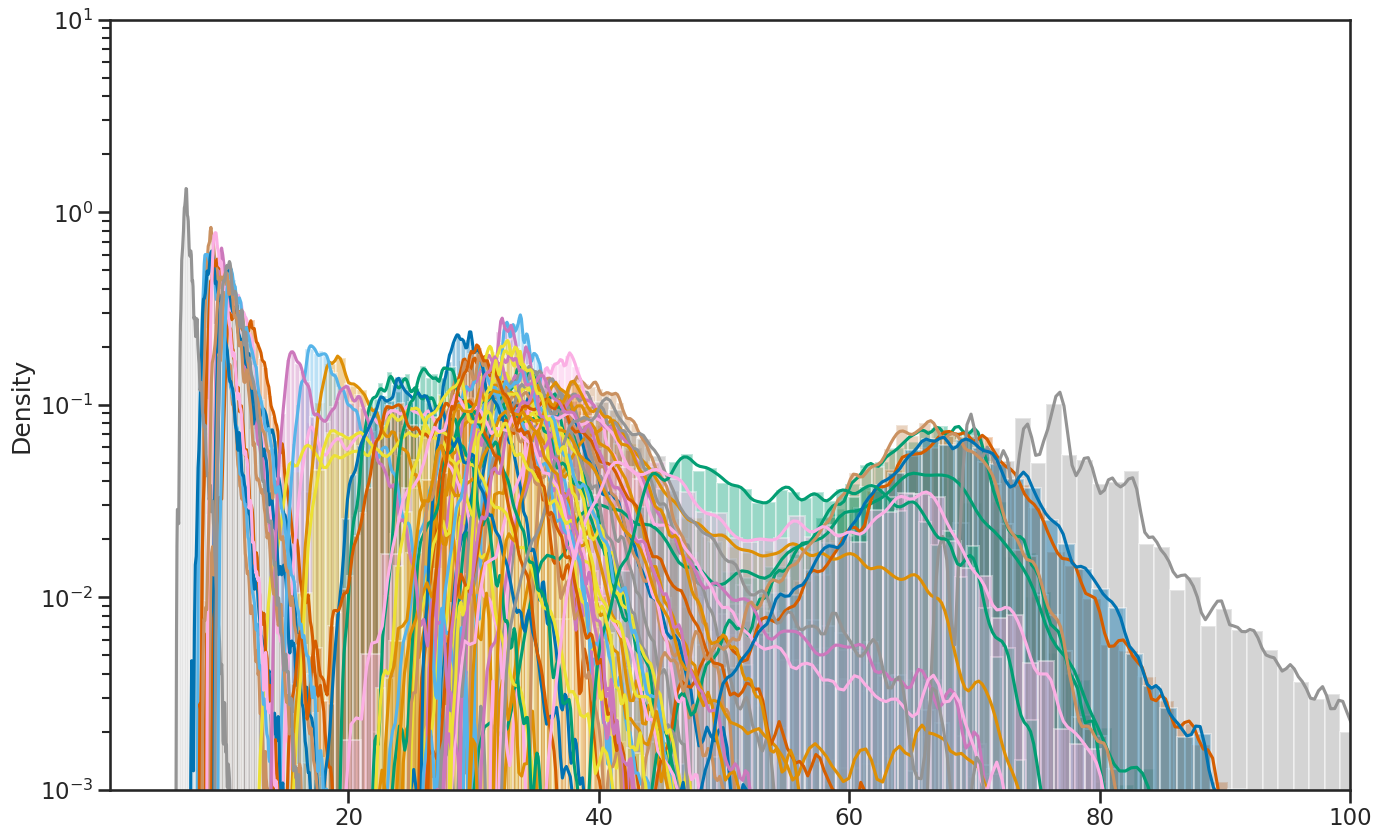

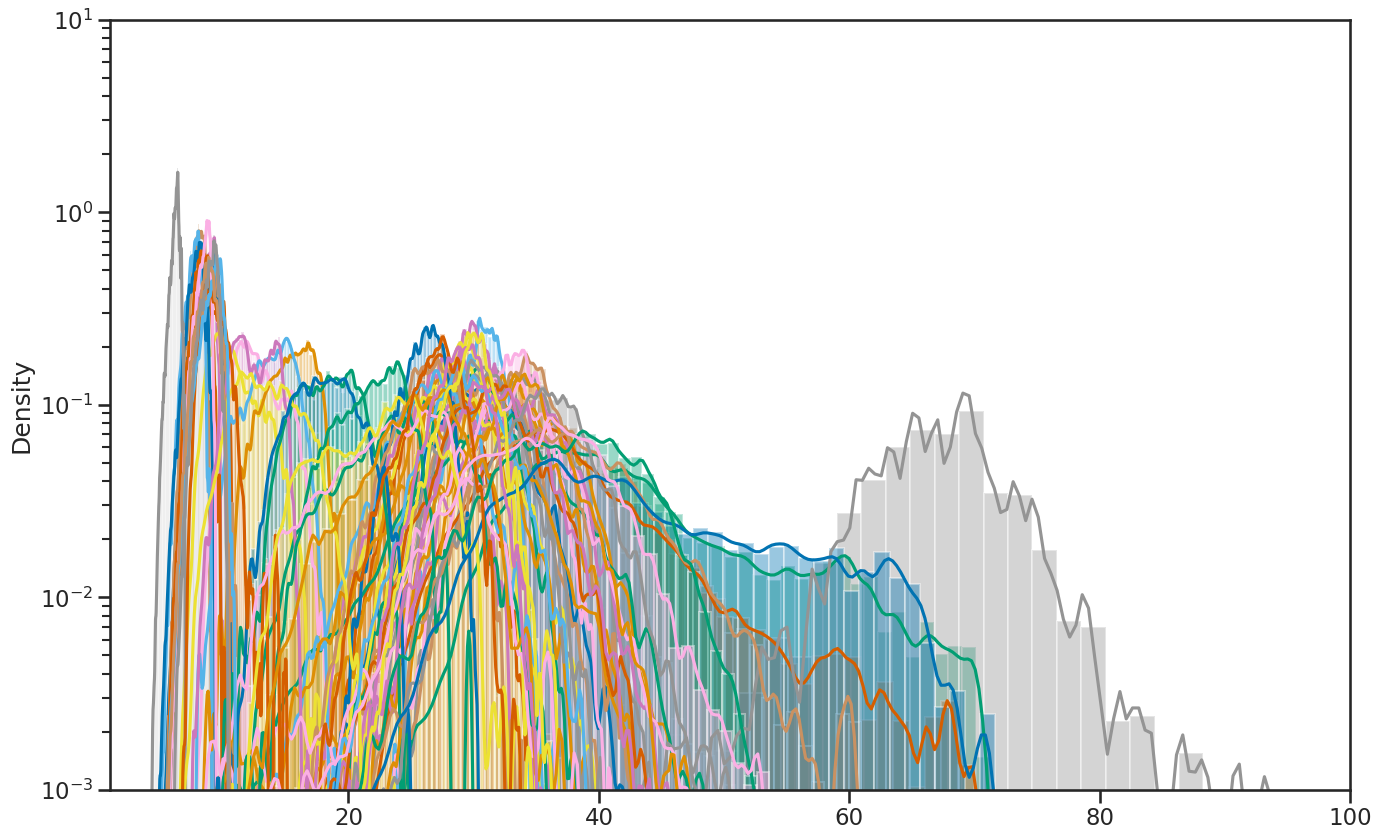

In [29]:
import warnings
warnings.filterwarnings("ignore")

plt.figure()
for k in range(nEvents):
    sns.distplot(m1[k,:])
plt.yscale('log')
plt.xlim(1,100)
plt.ylim(1e-3,10)
plt.show()

plt.figure()
for k in range(nEvents):
    sns.distplot(m2[k,:])
plt.yscale('log')
plt.xlim(1,100)
plt.ylim(1e-3,10)
plt.show()


In [30]:
# plt.figure()
# for k in range(nEvents):
#     sns.kdeplot(x=m1[k,:],y=m2[k,:],levels=[0.1])
# plt.xlim(0,150)
# plt.ylim(0,150)
# plt.show()

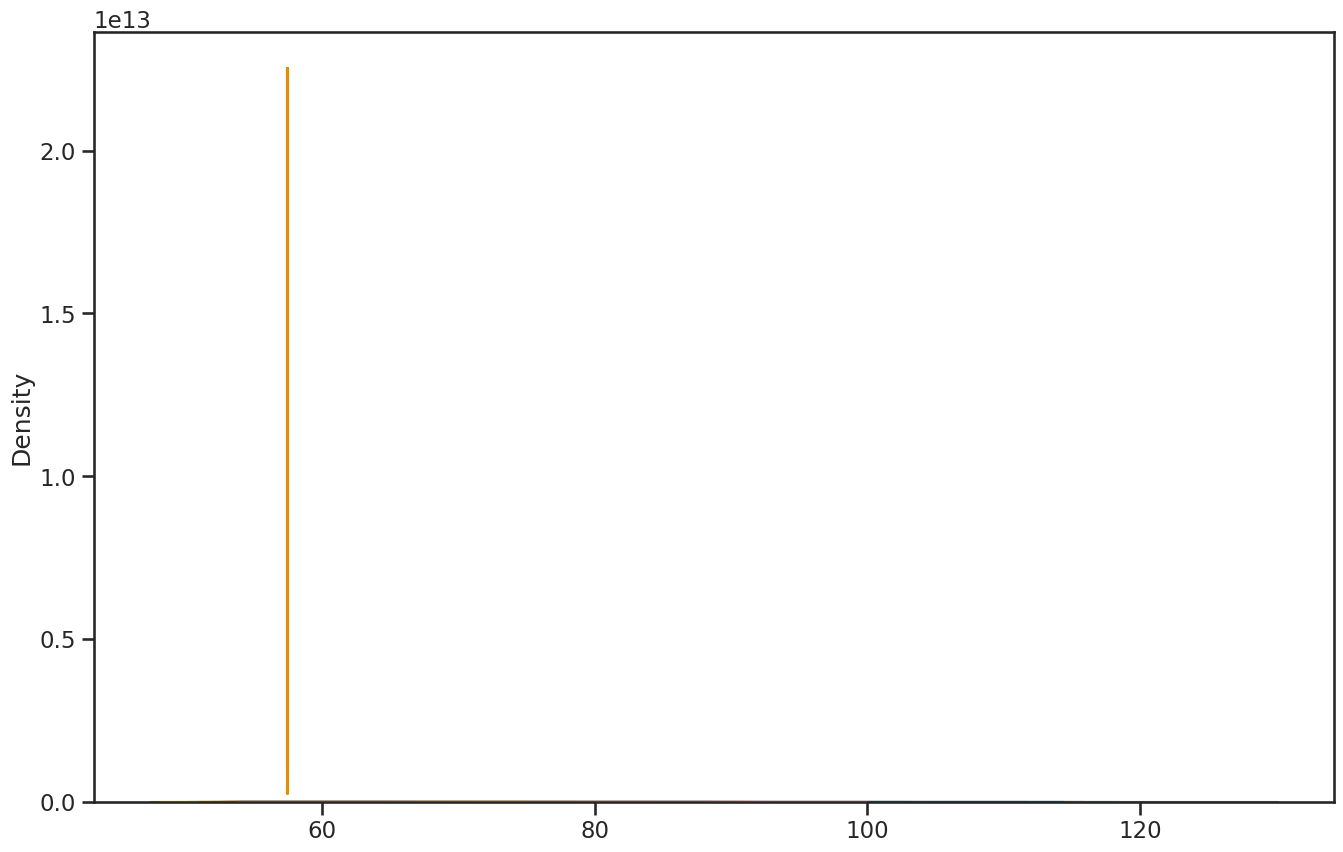

In [31]:
mth = 55
fm1s = []
fm2s = []
for k in range(nEvents):
    fm1s.append(np.sum(m1[k,:]>mth)/len(m1[k,:]))
    fm2s.append(np.sum(m2[k,:]>mth)/len(m2[k,:]))
    sns.distplot(m1[k,:][m1[k,:]>mth])
plt.show()

In [32]:
sum(fm1s),sum(fm2s),sum(fm1s)+sum(fm2s)

(Array(6.73999922, dtype=float64),
 Array(1.35683906, dtype=float64),
 Array(8.09683828, dtype=float64))

In [33]:
np.where(np.array(fm1s)>0.5)

(array([12, 22, 23, 27, 55, 60]),)

In [34]:
np.where(np.array(fm2s)>0.5)

(array([27]),)

In [35]:
names = open("../thesixtynine.txt").read().split()


In [36]:
idx_bump = list(np.where(np.array(fm1s)>0.5)[0])

In [37]:
names_bump = []
for idx in idx_bump:
    names_bump.append(names[idx])

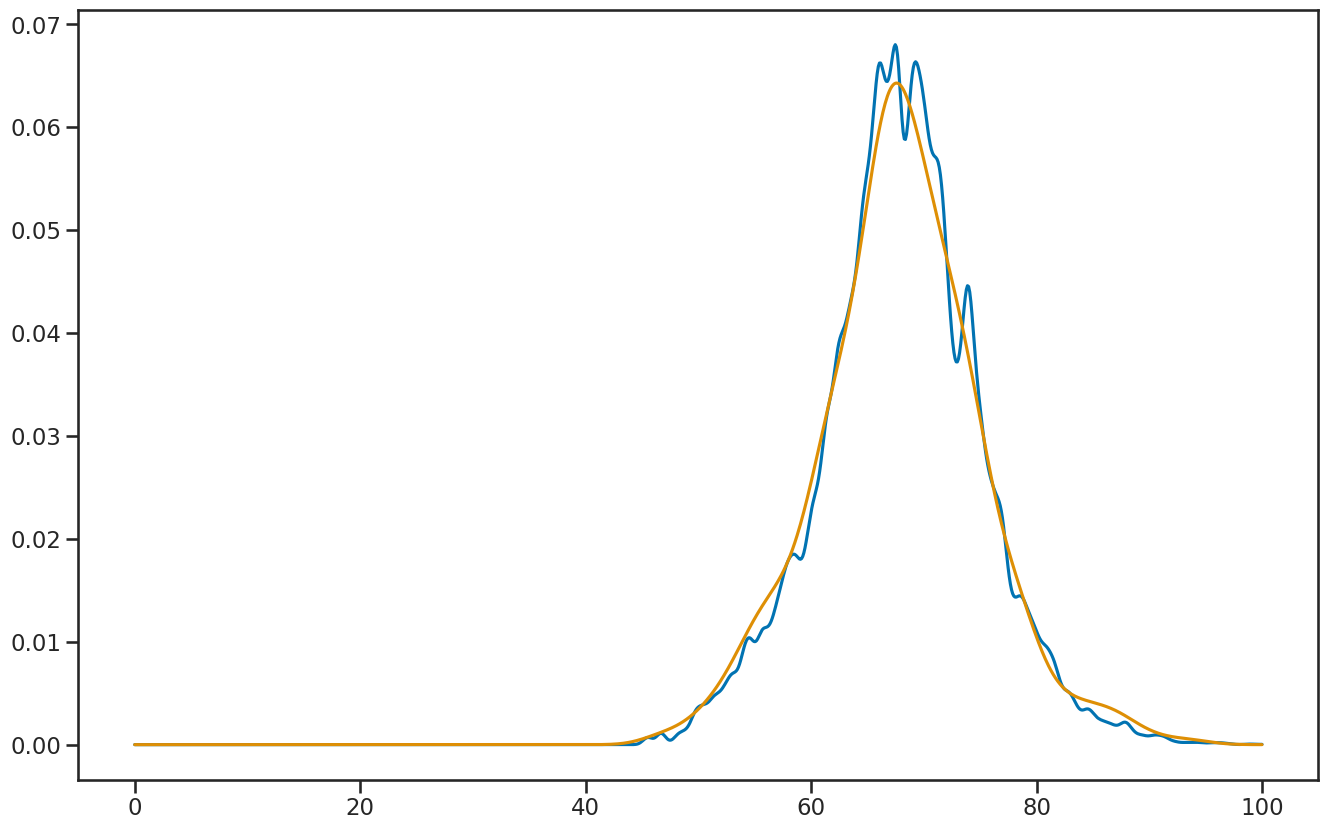

In [41]:
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

mass = np.linspace(0,100,1000)

kde = gaussian_kde(m1[k,:][np.random.randint(0,len(m1[k,:]),1000)]).evaluate(mass)

plt.plot(mass,kde)
plt.show()

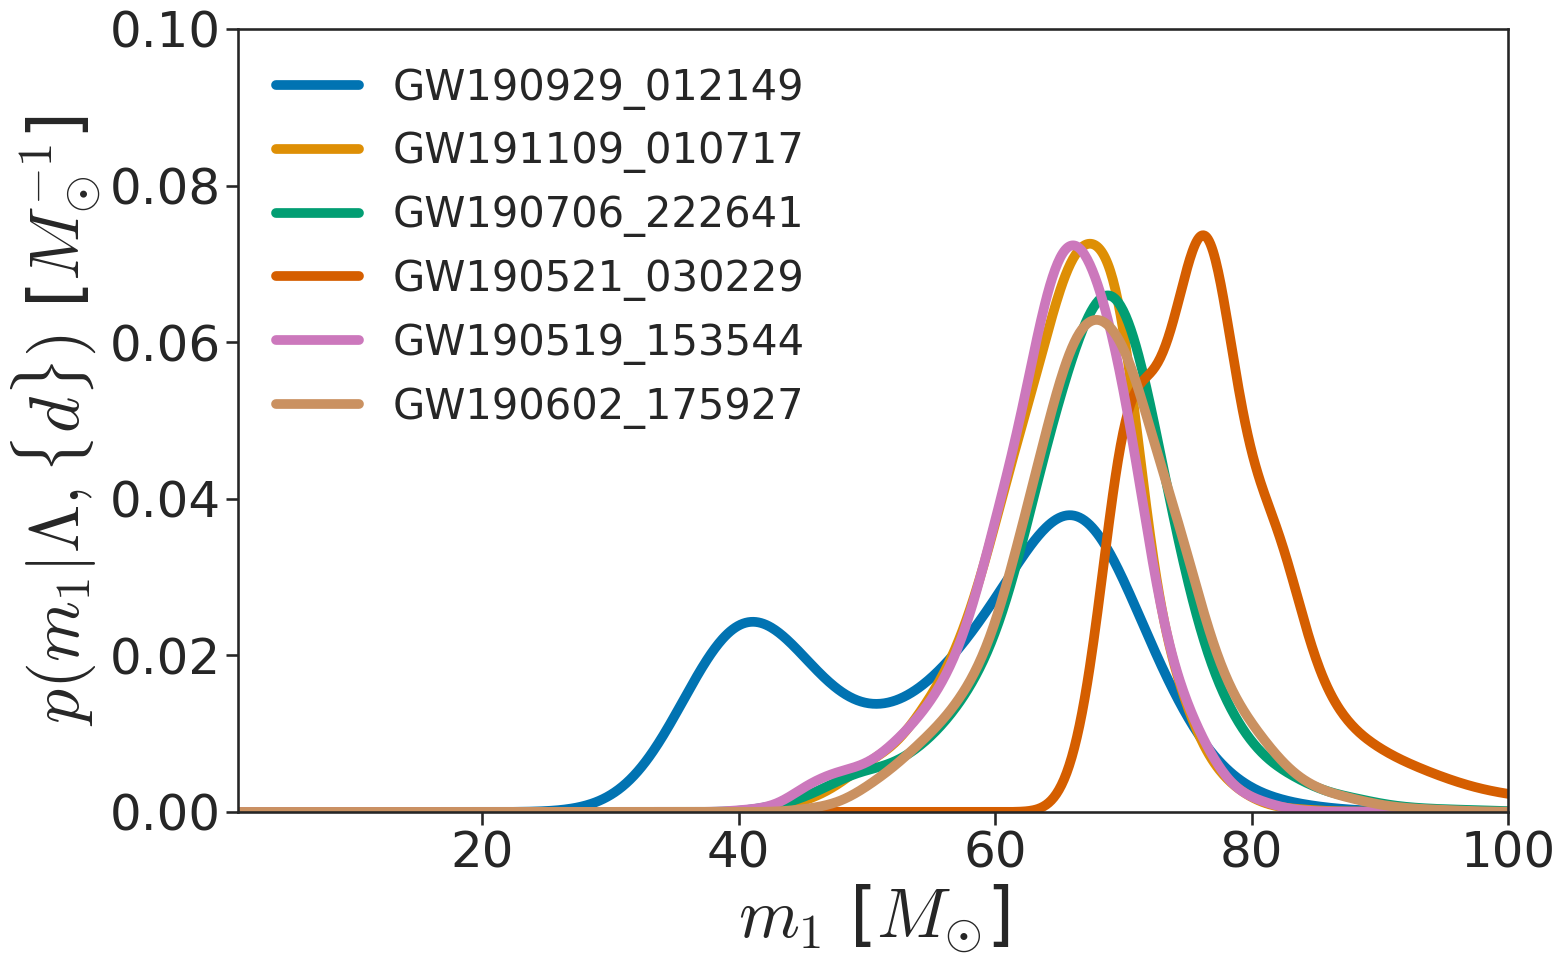

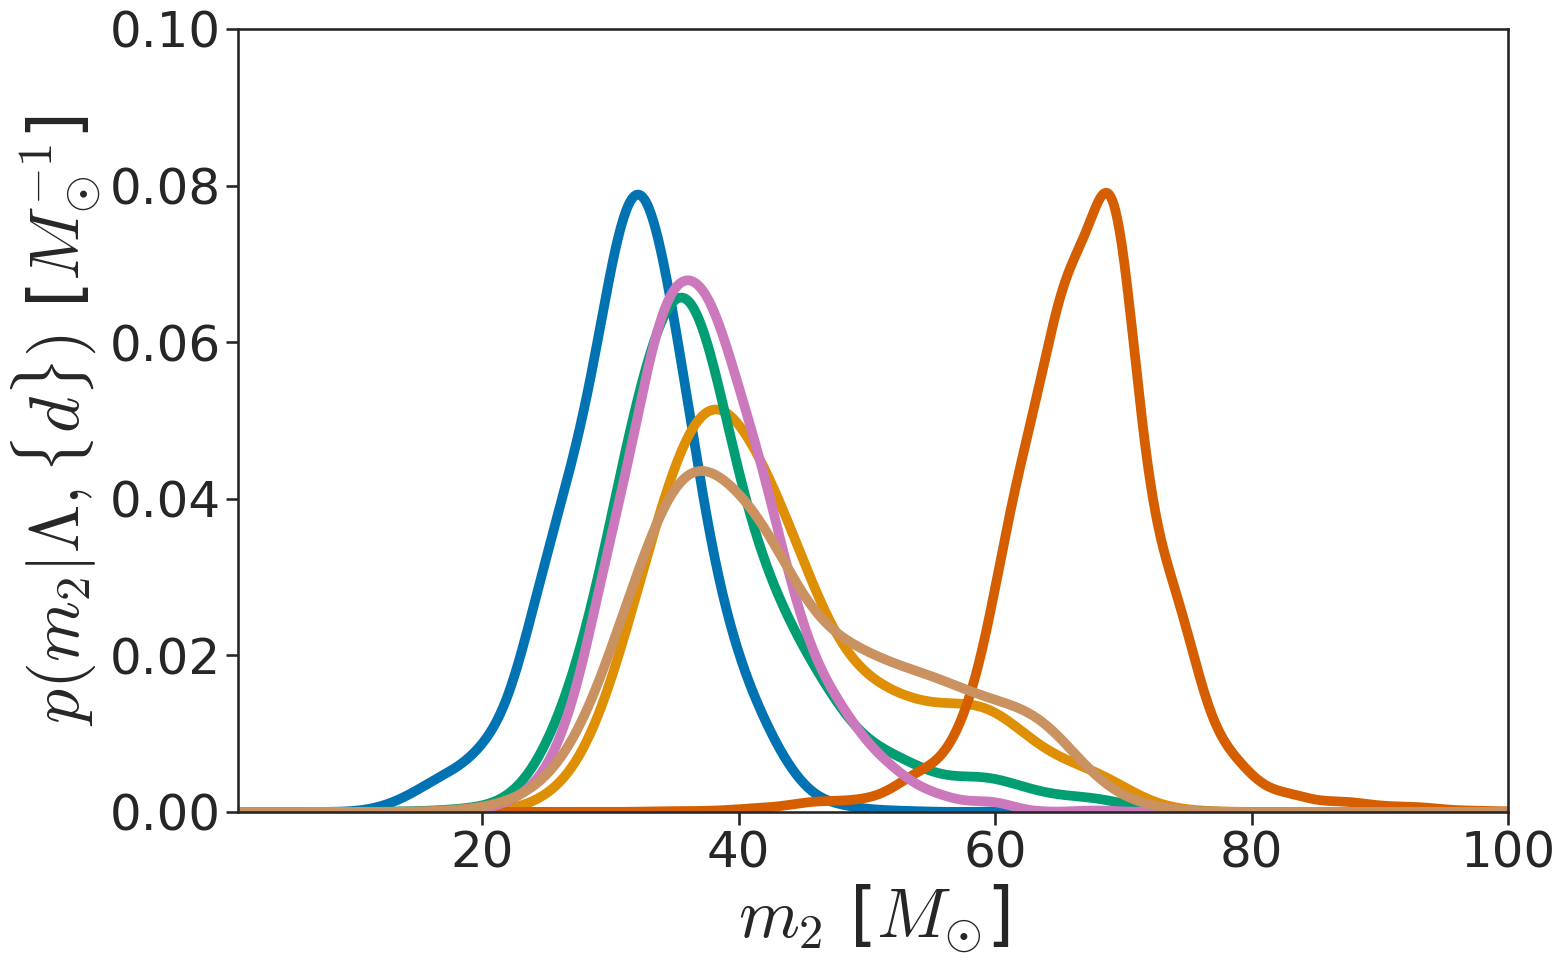

In [51]:
import warnings
warnings.filterwarnings("ignore")

mass = np.linspace(0,100,1000)

fig, axs = plt.subplots(figsize=(16,10))
for k in idx_bump:
    kde = np.zeros(len(mass))
    for j in range(50):
        kde += gaussian_kde(m1[k,:][np.random.randint(0,len(m1[k,:]),1000)]).evaluate(mass)    
    kde = kde/np.trapz(kde,mass)
    plt.plot(mass,kde,label=names[k],linewidth=7)
axs.set_xlim(1,100)
axs.set_ylim(0,0.10)
axs.set_xlabel("$m_{1}$ [$M_{\\odot}$]",fontsize=50)
axs.legend(loc="best",fontsize=30,frameon=False)
ylabel = "$p(m_1|\Lambda, \{d\})$ [$M_{\\odot}^{-1}$]"
axs.set_ylabel(ylabel,fontsize=50)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
plt.savefig('m1_events.pdf',bbox_inches='tight',dpi=200)
plt.show()

fig, axs = plt.subplots(figsize=(16,10))
for k in idx_bump:
    kde = np.zeros(len(mass))
    for j in range(50):
        kde += gaussian_kde(m2[k,:][np.random.randint(0,len(m2[k,:]),1000)]).evaluate(mass)    
    kde = kde/np.trapz(kde,mass)
    plt.plot(mass,kde,label=names[k],linewidth=7)
axs.set_xlim(1,100)
axs.set_ylim(0,0.10)
axs.set_xlabel("$m_{2}$ [$M_{\\odot}$]",fontsize=50)
ylabel = "$p(m_2|\Lambda, \{d\})$ [$M_{\\odot}^{-1}$]"
axs.set_ylabel(ylabel,fontsize=50)
plt.xticks(fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
plt.savefig('m2_events.pdf',bbox_inches='tight',dpi=200)

plt.show()


In [ ]:
m1.shape

In [ ]:
plt.figure()
for k in idx_bump:
    sns.kdeplot(x=m1[k,:],y=m2[k,:],levels=[0.1],label=names[k])
plt.xlim(0,150)
plt.ylim(0,150)
plt.legend()
plt.show()